In [1]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data
dataset = pd.read_csv(os.path.join(DATAPATH, "constraint", "autosomal_perlocus_estimates.bed"))

# 4A Example loci - CODIS/disease/autism

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

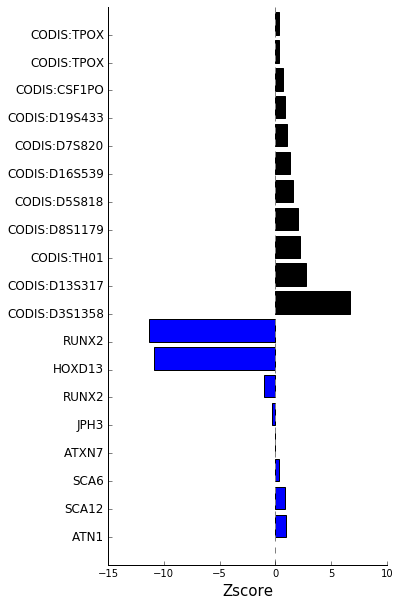

In [20]:
# Load CODIS/disease loci

col = "zscore_1"

loci = pd.read_csv(os.path.join(DATAPATH, "strsets", "loci_for_figure.bed"), names=["chrom","start","end","marker"], sep="\t")
loci = pd.merge(dataset, loci, on=["chrom","start","end"])

def GetColor(x):
    if "CODIS" in x["marker"]: return "black"
    else: return "blue"

def GetCat(x):
    if "CODIS" in x["marker"]: return "A_CODIS"
    else: return "C_DISEASE"
        
loci = loci.sort("marker")
loci["color"] = loci.apply(lambda x: GetColor(x), 1)
loci["cat"] = loci.apply(lambda x: GetCat(x), 1)
loci = loci.sort("marker")
rm = loci[loci["start"] == 45582231]
loci = loci[loci["start"] != 45582231]
loci = pd.concat([loci, rm.iloc[0:1,:]])
loci["gene"] = "NA"

# Load marshfield
#marsh = pd.read_csv(os.path.join(DATAPATH, "strsets","marshfield_loci.bed"), names=["chrom","start","end","period","marker"], sep="\t")
#marsh = pd.merge(dataset, marsh, on=["chrom","start","end"])
#marsh["color"] = "purple"
#marsh["gene"] = "NA"
#marsh["marker"] = marsh["marker"].apply(lambda x: "B_Marshfield:%s"%x)
#loci = pd.concat([loci, marsh])

# Load autism
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()
#coding = coding[coding["gene"].apply(lambda x: "." not in x and "-AS" not in x)]
autism = (pd.read_csv(os.path.join(DATAPATH, "strsets","autism_sfari_genes_bycategory.csv")))
autism["gene"] = autism["Gene Symbol"]

for category in ["1","2"]: #,"3","4","5"]:
    autism_genes = set(autism[autism["category"].apply(lambda x: category in str(x))]["Gene Symbol"])
    newloci = coding[coding.apply(lambda x: x["gene"] in autism_genes, 1)]
    newloci["cat"] = "D_Autism:%s"%category
    newloci["color"] = "blue"
    newloci["marker"] = newloci["gene"]
    #loci = pd.concat([loci, newloci])

# Add top and bottom to list
coding["cat"] = "E_coding"
coding["marker"] = coding["gene"]
coding["color"] = "green"
#loci = pd.concat([loci, coding.sort("diff_1").head(n=5)])
#loci = pd.concat([loci, coding.sort("diff_1").tail(n=5)])
    
loci = loci.sort(["cat",col], ascending=False)
fig = plt.figure()
fig.set_size_inches((5, 10))
ax = fig.add_subplot(111)
ax.barh(range(loci.shape[0]), loci["zscore_1"], color=loci["color"])
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.axvline(0, linestyle="dashed", color="gray")
ax.set_ylim(bottom=-1, top=loci.shape[0]);
ax.set_yticks(range(loci.shape[0]));
ax.set_yticklabels(loci["marker"], size=12);
ax.set_xlabel("Zscore", size=15);
fig.savefig(os.path.join(PLOTDIR, "Figure4_ConstraintExamples.pdf"))

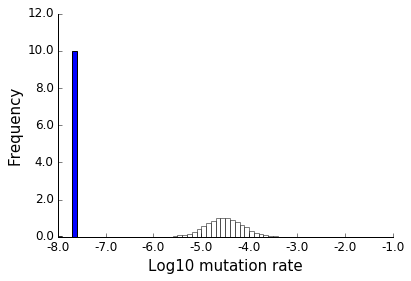

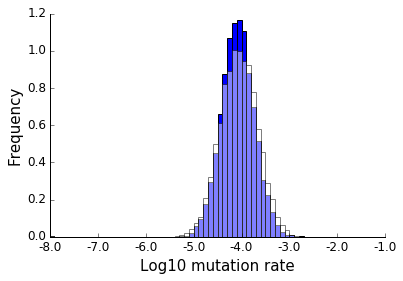

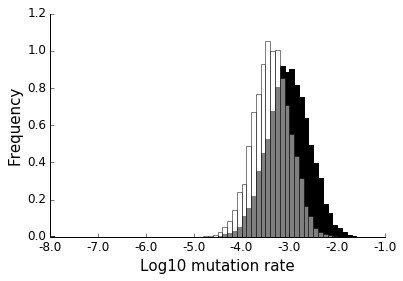

In [21]:
starts = [45390419, 63898361, 30417141]
colors = ["blue","blue","black"]
xvals = np.arange(-8, -1, 0.1)

for i in range(len(starts)):
    x = loci[loci["start"]==starts[i]]
    color = colors[i]
    
    obs_mu = x["ml_mu"].values[0]
    obs_mu_se = x["ml_mu_stderr"].values[0]
    if obs_mu_se <= 0: obs_mu_se = 0.001
    exp_mu = x["pred_mu_1"].values[0]
    exp_mu_se = x["pred_mu_se_1"].values[0]
    
    obs = np.random.normal(loc=obs_mu, scale=obs_mu_se, size=10000)
    exp = np.random.normal(loc=exp_mu, scale=exp_mu_se, size=10000)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(obs, bins=xvals, color=color, lw=1, normed=True);
    ax.hist(exp, bins=xvals, color="white", lw=1, edgecolor="black", normed=True, alpha=0.5);
    ax.spines["top"].set_visible(False);
    ax.spines["right"].set_visible(False);
    ax.get_xaxis().tick_bottom();
    ax.get_yaxis().tick_left();
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.set_xlabel("Log10 mutation rate", size=15)
    ax.set_ylabel("Frequency", size=15);
    fig.savefig(os.path.join(PLOTDIR, "Figure4_Example_%s.pdf"%starts[i]))

In [29]:
loci[loci["marker"]=="RUNX2"]

,chrom,start,end,ml_mu,ml_mu_stderr,motif,uninterrupted_length,pred_mu_1,pred_mu_se_1,pred_mu_2,...,filter2,zscore_1,zscore_2,diff_1,diff_2,diff_3,marker,color,cat,gene
19,6,45390487,45390531,-6.001144,1.858261,CCG,17,-4.648554,0.386377,-6.650425,...,False,-1.007822,0.433945,-1.352589,0.649281,-1.284843,RUNX2,blue,C_DISEASE,NA
18,6,45390419,45390484,-7.620128,-9.144153,AGC,20,-4.531046,0.386372,-6.254803,...,False,-11.306767,-1.907859,-3.089082,-1.365324,-3.042417,RUNX2,blue,C_DISEASE,NA


# GO analysis

In [22]:
# Download files
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy
obo_fname = download_go_basic_obo()
gene2go = download_ncbi_associations()

# Load data
obodag = GODag("go-basic.obo")
geneid2gos_human = read_ncbi_gene2go("gene2go", taxids=[9606])

# Load coding
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()

  EXISTS: go-basic.obo
  EXISTS: gene2go
load obo file go-basic.obo
go-basic.obo: fmt(1.2) rel(2016-11-26) 47,820 GO Terms


In [23]:
sys.path.append("/Users/gymrek/workspace/goatools/goatools/test_data/")
from genes_NCBI_9606_ProteinCoding import GeneID2nt
geneSymbolToID = {}
strgenes = set(coding["gene"])
for geneid in GeneID2nt.keys():
    nt = GeneID2nt.get(geneid)
    symbol = nt.Symbol
    if symbol in strgenes:
        geneSymbolToID[symbol] = geneid
background_ids = geneSymbolToID.values()
all_human_ids = GeneID2nt.keys()
coding["geneid"] = coding["gene"].apply(lambda x: geneSymbolToID.get(x, -1))

In [24]:
# Enrichment of STR genes in general
goeaobj = GOEnrichmentStudy(
        all_human_ids, # List of human protein-coding genes
        geneid2gos_human, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = True,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method
goea_results_all = goeaobj.run_study(background_ids)
goeaobj.wr_txt("all_str_genes.txt", goea_results_all)

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


18,332 out of 20,913 population items found in association
Calculating uncorrected p-values using fisher_scipy_stats
 1,082 out of  1,133 study items found in association
Running multitest correction: statsmodels fdr_bh
  8,205 GO terms are associated with 1,082 of 1,133 study items
  20,916 GO terms are associated with 18,332 of 20,913 population items
  20916 items WROTE: all_str_genes.txt


In [25]:
# Initialize GOEA object
goeaobj = GOEnrichmentStudy(
        background_ids, # List of human protein-coding genes
        geneid2gos_human, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = True,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 1,082 out of  1,133 population items found in association


# Coding analysis - supp table 5

In [3]:
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()

In [4]:
coding = coding[coding["gene"].apply(lambda x: "." not in x)]
coding.sort("zscore_1")[["chrom","start","motif","gene","zscore_1"]].head(n=10)

,chrom,start,motif,gene,zscore_1
1679,18,19752073,ACC,GATA6,-12.883983
302,2,5833526,ACG,SOX11,-12.597263
1479,14,99641544,AGG,BCL11B,-12.310521
1632,17,40345560,AGC,GHDC,-12.023768
1667,17,71205859,AGC,FAM104A,-12.023767
2041,8,28209226,AGC,ZNF395,-12.023764
694,3,129546680,AGC,TMCC1,-11.880383
1820,19,51961617,AGC,SIGLEC8,-11.880382
540,2,237076427,CCG,GBX2,-11.880378
418,2,105472776,ACC,POU3F3,-11.880376


In [5]:
coding.sort("zscore_1")[["chrom","start","motif","gene","zscore_1"]].tail(n=11)

,chrom,start,motif,gene,zscore_1
2078,9,35561913,ACCC,FAM166B,2.783935
1152,10,21805467,AGG,SKIDA1,2.970820
924,5,112824025,AGC,MCC,4.092337
34,1,17026022,CCG,ESPNP,4.208970
1404,13,25671799,AGC,PABPC3,4.986086
558,3,18391133,AGC,SATB1,5.179028
559,3,18391133,AGC,TBC1D5,5.179028
1753,19,39019599,AGG,RYR1,8.354111
1162,10,29821971,AAG,SVIL,9.356209
1979,7,73462847,AGC,ELN,10.085285


# Gene level analysis - multiple STRs/gene

In [117]:
print coding.shape
print len(set(coding.gene))

(1424, 20)
1180


In [80]:
strspergene = coding.groupby("gene", as_index=False).agg({"start":len})
for i in range(1, 6):
    print i, list(strspergene.start).count(i)*1.0/len(strspergene)
    
# For all genes with 2 STRS, get:
#  diff in score between the 2 strs
#  diff in score between 1st str and random other str
testgenes = strspergene[strspergene.start==2].gene
diff_samegene = []
diff_diffgene = []
for gene in testgenes:
    x = coding[coding["gene"]==gene]["zscore_1"].values
    diff_samegene.append(abs(x[1]-x[0]))
# now choose  str pairs
for i in range(coding.shape[0]):
    for j in range(coding.shape[0]):
        if i >=j: continue
        if coding["gene"].values[i] == coding["gene"].values[j]: continue
        constrandom1 = coding["zscore_1"].values[i]
        constrandom2 = coding["zscore_1"].values[j]
        diff_diffgene.append(abs(constrandom2-constrandom1))

print np.median(diff_samegene)
print np.median(diff_diffgene)
print scipy.stats.mannwhitneyu(diff_samegene, diff_diffgene, alternative="less")
print len(diff_samegene), len(diff_diffgene)

1 0.837288135593
2 0.131355932203
3 0.021186440678
4 0.00762711864407
5 0.00254237288136
1.0040276449
2.31759646481
MannwhitneyuResult(statistic=72665858.5, pvalue=0.054611432255157667)


# Gene level analysis - ExAC

In [91]:
missenseZ = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_missense_scores_coding.bed.gz"), sep="\t", names=["chrom","start","end","missenseZ"])
pLI = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_pLI_scores_coding.bed.gz"), sep="\t", names=["chrom","start","end","pLI"])
coding_exac = pd.merge(coding, missenseZ, on=["chrom","start","end"])
coding_exac = pd.merge(coding_exac, pLI, on=["chrom","start","end"]).drop_duplicates()

In [115]:
# Correlation with pLI (expect negative correlation)
print scipy.stats.pearsonr(coding_exac["zscore_1"], coding_exac["pLI"])

# Mean constraint score for pLI>0.9
print np.mean(coding_exac[coding_exac["pLI"]>0.9]["zscore_1"])

# Mean constraint score for pLI<=0.9
print np.mean(coding_exac[coding_exac["pLI"]<=0.9]["zscore_1"])

# Compare
print scipy.stats.mannwhitneyu(coding_exac[coding_exac["pLI"]>0.9]["zscore_1"],
                               coding_exac[coding_exac["pLI"]<=0.9]["zscore_1"], alternative="less")
print len(coding_exac[coding_exac["pLI"]>0.9]["zscore_1"]), len(coding_exac[coding_exac["pLI"]<=0.9]["zscore_1"])

# Correlation with missenseZ (expect negative correlation)
print scipy.stats.pearsonr(coding_exac["zscore_1"], coding_exac["missenseZ"])

# Mean constraint score for high constrained
print np.mean(coding_exac[coding_exac["missenseZ"]>3]["zscore_1"])

# Mean constraint score for low constrained
print np.mean(coding_exac[coding_exac["pLI"]<=3]["zscore_1"])

# Compare
print scipy.stats.mannwhitneyu(coding_exac[coding_exac["missenseZ"]>3]["zscore_1"],
                               coding_exac[coding_exac["missenseZ"]<=3]["zscore_1"], alternative="less")
print len(coding_exac[coding_exac["missenseZ"]>3]["zscore_1"]), len(coding_exac[coding_exac["missenseZ"]<=3]["zscore_1"])


(-0.39524437756834907, 2.2449530676974807e-298)
-6.71751317206
-1.44762789148
MannwhitneyuResult(statistic=741825.0, pvalue=1.4595557788448158e-97)
463 7564
(0.033111801781827994, 0.0030076537563730184)
-6.59558493592
-1.75159660768
MannwhitneyuResult(statistic=492372.0, pvalue=2.5142886165074962e-51)
272 7755


In [103]:
# Cases where disagree? - unconstrained STR in high pLI gene - 21 cases
coding_exac[(coding_exac["zscore_1"]>0) & (coding_exac["pLI"]>0.9)]

,chrom,start,end,gene,ml_mu,ml_mu_stderr,motif,uninterrupted_length,pred_mu_1,pred_mu_se_1,...,pred_mu_3,filter1,filter2,zscore_1,zscore_2,diff_1,diff_2,diff_3,missenseZ,pLI
240,1,117122270,117122290,IGSF3,-4.095632,0.346712,ACG,21,-4.491876,0.386371,...,-4.513479,False,False,1.079457,2.679977,0.396244,2.027298,0.417847,3.615578,0.993129
284,1,153907273,153907323,DENND4B,-3.785561,0.188313,AGC,27,-4.256859,0.386368,...,-4.340362,False,False,1.550699,2.124043,0.471298,1.546126,0.554801,2.959020,0.999952
600,2,85360819,85360867,TCF7L1,-4.195118,0.393814,CCG,21,-4.491876,0.386371,...,-4.513479,False,False,0.760704,2.510492,0.296759,1.927812,0.318361,1.267260,0.980667
836,2,232325406,232325437,NCL,-4.765647,0.345501,ATC,14,-4.766063,0.386382,...,-4.582507,False,False,0.001134,3.015663,0.000416,2.280399,-0.183140,-0.091022,0.997948
852,2,233712201,233712246,GIGYF2,-4.252160,0.271320,AGC,19,-4.570215,0.386374,...,-4.513591,False,False,0.952715,2.880970,0.318055,2.134517,0.261430,1.545890,1.000000
1104,3,113376105,113376147,KIAA2018,-3.506228,0.193939,AGC,37,-3.865164,0.386375,...,-3.657905,False,False,1.174165,0.695412,0.358935,0.506720,0.151677,-0.729226,0.999831
1276,4,15004879,15004901,CPEB2,-4.715934,0.450252,CCG,15,-4.726893,0.386380,...,-4.551363,False,False,0.026123,2.806532,0.010960,2.198239,-0.164571,2.859911,0.997275
1584,5,113698626,113698645,KCNN2,-4.337163,0.311697,CCG,14,-4.766063,0.386382,...,-4.582507,False,False,1.221827,3.617613,0.428900,2.708883,0.245344,2.538482,0.956750
28664,5,153085669,153085695,GRIA1,-3.859943,0.264582,AAAC,27,-4.360673,0.386332,...,-4.474210,False,False,1.512320,2.282418,0.500731,1.688234,0.614268,4.280704,0.999950
28817,10,29821971,29822015,SVIL,-2.209821,-2.651785,AAG,14,-4.766063,0.386382,...,-4.582507,True,False,9.356209,6.757972,2.556242,4.836225,2.372686,1.286066,0.998814


In [113]:
# Cases where disagree? - constrained STR in low constrained gene
coding_exac[(coding_exac["zscore_1"]<-10) & (coding_exac["pLI"]<=0.5)]

,chrom,start,end,gene,ml_mu,ml_mu_stderr,motif,uninterrupted_length,pred_mu_1,pred_mu_se_1,...,pred_mu_3,filter1,filter2,zscore_1,zscore_2,diff_1,diff_2,diff_3,missenseZ,pLI
0,1,6509025,6509050,ESPN,-7.619649,-9.143579,CCG,14,-4.766063,0.386382,...,-4.582507,True,False,-10.444532,-0.801533,-2.853586,-0.573603,-3.037142,-0.248355,1.605421e-03
20,1,11866344,11866373,CLCN6,-7.620135,-9.144163,AGC,12,-4.844402,0.386387,...,-4.707731,True,False,-10.159461,-0.433660,-2.775733,-0.310342,-2.912405,1.595947,6.296914e-02
36,1,17298016,17298043,CROCC,-7.620134,-9.144161,AGC,14,-4.766063,0.386382,...,-4.582507,True,False,-10.446305,-0.802210,-2.854071,-0.574088,-3.037627,-0.848596,1.715024e-19
40,1,19282726,19282772,IFFO2,-7.620132,-9.144158,CCG,17,-4.648554,0.386377,...,-4.716301,True,False,-10.876555,-1.355036,-2.971578,-0.969707,-2.903831,2.161521,3.572552e-01
56,1,22263665,22263687,HSPG2,-7.620109,-9.144130,AGC,11,-4.883572,0.386389,...,-4.559413,True,False,-10.015934,-0.249347,-2.736537,-0.178441,-3.060696,0.776375,1.794044e-06
60,1,22970558,22970583,C1QC,-7.620136,-9.144163,AGC,13,-4.805232,0.386384,...,-4.553559,True,False,-10.302889,-0.617937,-2.814903,-0.442216,-3.066577,0.749595,1.521076e-02
76,1,26126836,26126857,SEPN1,-7.620136,-9.144163,CCG,11,-4.883572,0.386389,...,-4.559413,True,False,-10.016034,-0.249385,-2.736564,-0.178468,-3.060723,0.631010,4.564939e-08
116,1,31836993,31837028,ZCCHC17,-7.620136,-9.144163,AAG,12,-4.844402,0.386387,...,-4.707731,True,False,-10.159461,-0.433660,-2.775733,-0.310342,-2.912405,-0.610907,1.685930e-01
120,1,32936639,32936683,ZBTB8B,-7.620131,-9.144157,CCG,11,-4.883572,0.386389,...,-4.559413,True,False,-10.016014,-0.249377,-2.736559,-0.178463,-3.060718,-0.010944,3.690972e-01
124,1,33065979,33065999,ZBTB8OS,-7.620131,-9.144157,AAG,15,-4.726893,0.386380,...,-4.551363,True,False,-10.589717,-0.986482,-2.893238,-0.705959,-3.068768,1.249606,3.025575e-01
